In [1]:
# Some initial setup
options(digits = 3)
library(tidyverse)
library(gbm)

theme_set(theme_bw())

# Read the data
kcDat <- read_rds('../data/kc_inspections.rds')

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loaded gbm 2.1.5


## The problem

We would like to design a risk score for restaurants to determine the allocation of health inspection resources. Ideally, the model would assign higher scores to restaurants most likely to receive higher inspection scores (meaning there are more violations), so that more resources would be allocated towards inspecting them. 

## The data

The `kcDat` data frame contains information on restaurant inspections in King County, Washington between 2015 and 2019. The inspection data has been merged with Yelp review information and some other variables have been engineered.


 - Variables of interest
      - `inspection_serial_num`: unique inspection identifier
      - `business_record_id`: unique restaurant identifer
      - `inspection_date`: date of inspection
      - `inspection_score`: score for inspection; higher scores mean there were more violations/penalties
      - `activity_time`: length of inspection in minutes
      - `year`: year the inspection occurred
      - `weekday`: day of week inspection occurred
      - `viol_count`: number of violations that occurred in inspection
      - `prev_score_1` through `prev_score_4`: score of four most recent previous inspections, prev_score_1 being most recent
      - `business_location_zip`: zip code where restaurant is located
      - `asian`: indicator that restaurant serves Asian food


## Data Visualization and Exploration

Let's first explore and visualize the data to understand it better and if there are any relationships between variables. Run this cell to see the first few lines of the data.

In [2]:
head(kcDat)

inspection_serial_num,business_record_id,inspection_date,inspection_score,activity_time,year,weekday,viol_count,prev_score_1,prev_score_2,⋯,ethiopian,indonesian,singaporean,grocery,asian,log_inspection_score,log_prev_score_1,log_prev_score_2,log_prev_score_3,log_prev_score_4
DAPXVWYJI,PR0001011,2015-03-30,10,25,2015,Monday,1,10,20,⋯,0,0,0,0,0,2.30,2.30,3.00,2.48,2.30
DAIQD6JTB,PR0001011,2015-06-23,15,40,2015,Tuesday,2,10,10,⋯,0,0,0,0,0,2.71,2.30,2.30,3.00,2.48
DAN2JKZZU,PR0001011,2016-03-21,20,30,2016,Monday,3,15,10,⋯,0,0,0,0,0,3.00,2.71,2.30,2.30,3.00
DA0UJUF5K,PR0001011,2016-08-16,15,30,2016,Tuesday,2,20,15,⋯,0,0,0,0,0,2.71,3.00,2.71,2.30,2.30
DACPGS7VE,PR0001011,2017-03-28,5,30,2017,Tuesday,1,15,20,⋯,0,0,0,0,0,1.61,2.71,3.00,2.71,2.30
DASZN0RMO,PR0001011,2018-10-29,5,40,2018,Monday,1,5,15,⋯,0,0,0,0,0,1.61,1.61,2.71,3.00,2.71


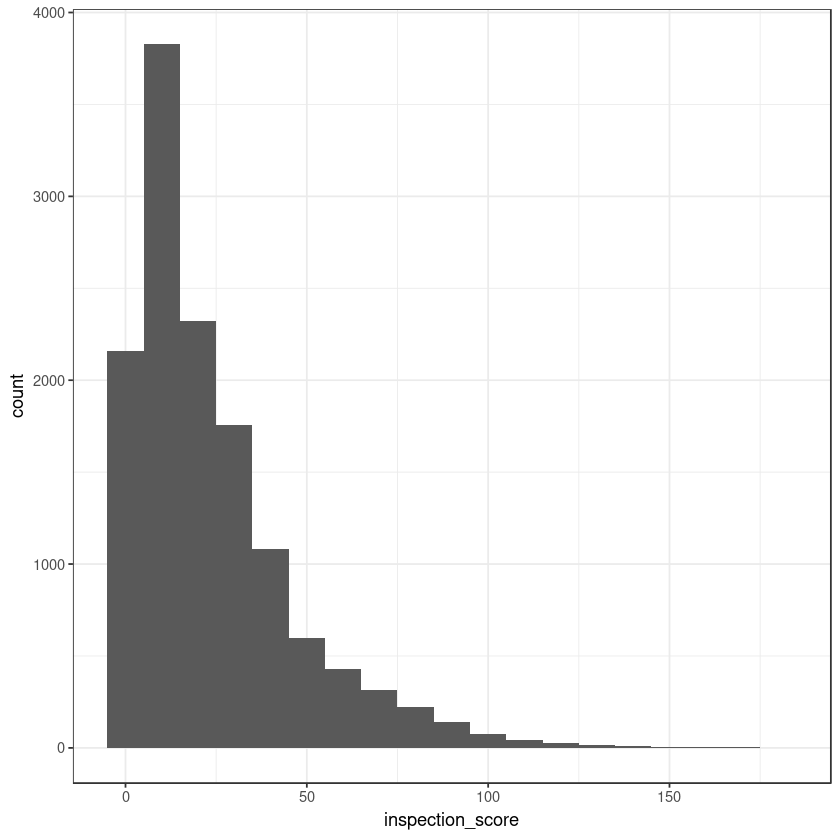

In [4]:
# Run this cell to see a histogram of our outcome variable, inspection_score
ggplot(kcDat, aes(x = inspection_score)) +
    geom_histogram(binwidth = 10)

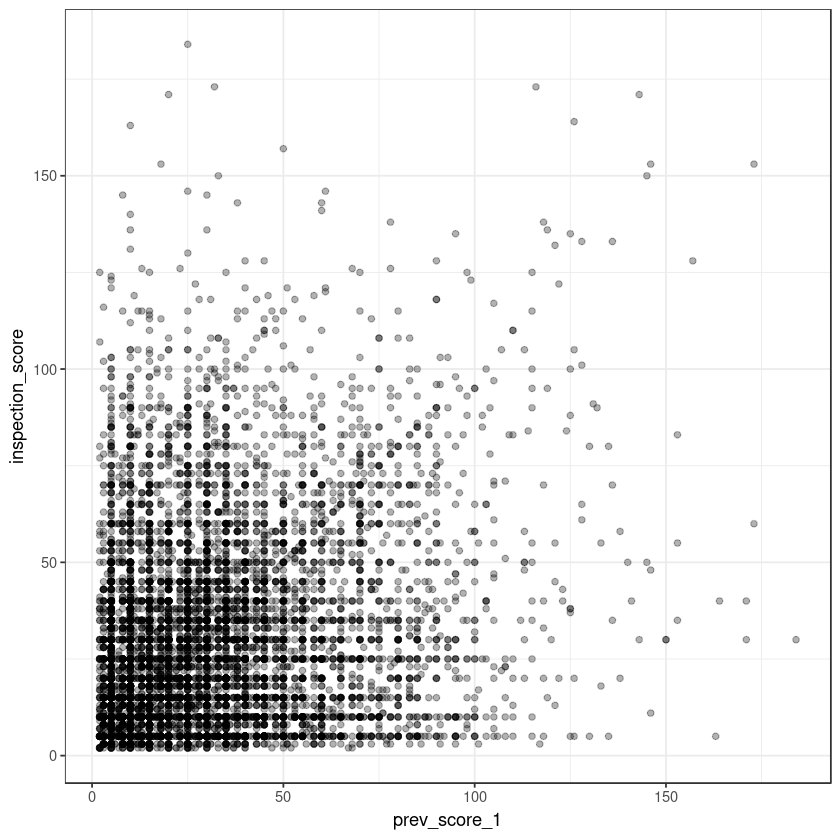

In [5]:
# Run this cell to see a scatter plot of inspection score against the most recent previous inspection score
ggplot(kcDat, aes(x = prev_score_1, y = inspection_score)) +
    geom_point(alpha = 0.3)

First, find the baseline prediction ability by taking a naive approach and imputing the mean as the predicted inspection score for all future inspections. We want to split up the data into a training and test set so we can test how well our model is performing on data it has never seen before.

In [5]:
# Get a random subset of data to fit naive model
# Take 80% of data to train - leave 20% to evaluate accuracy
train <- sample(1:nrow(kcDat),floor(nrow(kcDat)*.8),replace=FALSE)
train_sub <- kcDat[train,]
test_sub <- kcDat[-train,]

We can evaluate the prediction ability through the square root of mean squared error (RMSE). Mean squared error (MSE) is calculated as $\frac{\sum_{1}^{n}(prediction - observed)^2)}{n}$, which is the mean of the difference between the predicted values and observed values squared. Taking the square root of MSE puts it on a more interpretable scale. 

Use the mean of the inspection scores from the training subset as the predicted value for all observations in the test set. Calculate the RMSE and call it naive_rmse. 

In [6]:
## answer here 
naive_rmse <- sqrt(mean((test_sub$inspection_score - mean(train_sub$inspection_score))^2))


In [7]:
#run this cell to create a data frame with the result and output it
results <- data.frame(cbind(Model='Naive',RMSE=naive_rmse))
results

Model,RMSE
Naive,22.8355359689342


The RMSE is 22.83, so using this naive approach would mean that we would on average be predicting values about 23 points different from the actual inspection score given. Let's see if we can build a model that will be better than our naive approach.

## Fit a model to predict inspection scores

We'll first build a gradient boosted tree model using just the zip code location of the restaurants, because we think the quality of a restaurant might vary by geography and that this would affect inspection scores. We'll also include year to account for areas changing over time. Run the following cell to select the predictors included in the model and fit the gradient boosted tree.

In [8]:
#this selects the columns needed to fit the model - both the independent and dependent variables
gb_ziponly <- gbm(inspection_score~business_location_zip + year,
          data=train_sub,distribution = "gaussian",n.trees = 1000,shrinkage = 0.01)

## Assess prediction ability

Now that we've fit a model, we can compare the performance between our naive approach and the model. We'll calculate RMSE on the 20% of data we kept as a test set again and add it to the dataframe containing the RMSE from the naive approach. 

You can predict new values from your model using the `predict()` function. You can change the number of trees used to make predictions, but you cannot use more trees than were fit in the model. Name the variable that holds the rmse `zip_only`.

In [9]:
score_pred <- predict(gb_ziponly,newdata=test_sub,n.trees=1000)

#calculate RMSE here
zip_only <- sqrt(mean((score_pred - test_sub$inspection_score)^2))

In [10]:
results <- rbind(results,cbind(Model="Zip Code GBM",RMSE=zip_only))
results

Model,RMSE
Naive,22.8355359689342
Zip Code GBM,22.2351920154707


The RMSE for the model with just zip code and year has a slightly lower RMSE than the baseline, but not by much. 

We can also graphically show how well the model is predicting by plotting the predicted values against the observed values in two ways. The first is a calibration plot. This plot is typically used for models that predict probabilities of events occurring, but it can be adjusted for our use case. To create the calibration plot:
 1. create bins from the predicted scores
 2. calculate the mean of the observed scores in those created bins
 3. calculate midpoint of the bins
 4. count number of points in each bin
 5. plot the means against the midpoints

In [11]:
#create bins by observed violation count
#add the predicted scores to the test subset
test_sub$prediction <- score_pred
#you can create bins using the ntile function - this will create 15 bins
test_sub$countCat <- ntile(test_sub$prediction,15)

#this creates a function that returns the midpoint of a vector of numbers
midpoint <- function(x)mean(range(x))

#calculate the mean and midpoints, as well as the count of points in each bin
#name te data frame calibration_data, the mean score column 'meanScore', the midpoint 'predMidpoint' and the count 'n'
calibration_data <- test_sub %>%
                    group_by(countCat) %>%
                    summarize(meanScore = mean(inspection_score),
                              predMidpoint=midpoint(prediction),
                              n = n())

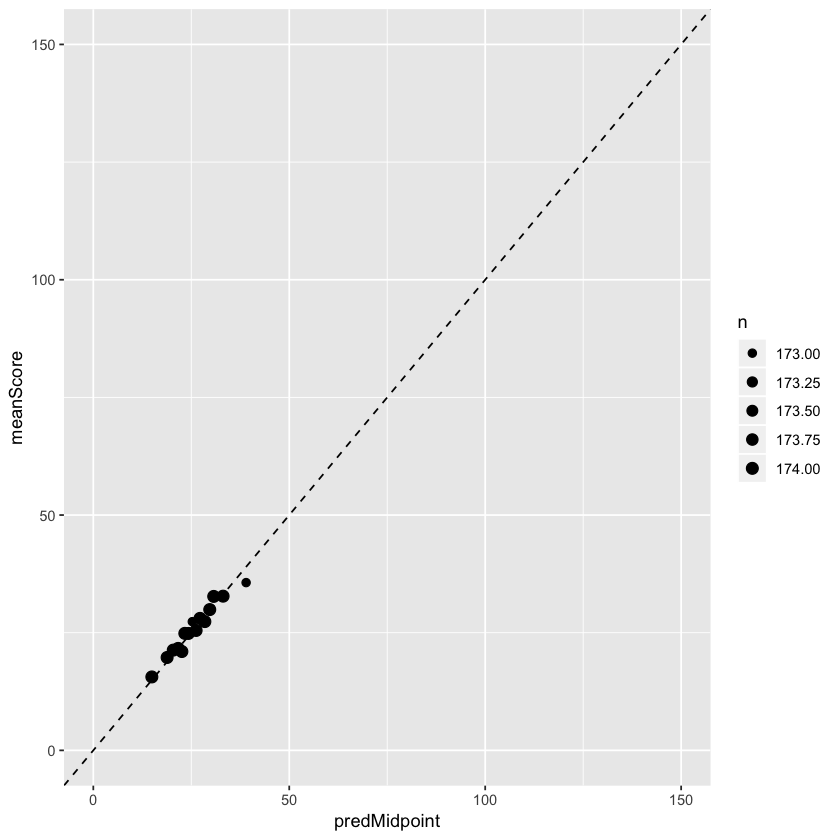

In [12]:
#run this cell to plot your result
ggplot(calibration_data,aes(x=predMidpoint,y=meanScore)) + geom_point(aes(size = n)) + geom_abline(linetype = "dashed") +
    scale_x_continuous(limits = c(0, 150)) +
    scale_y_continuous(limits = c(0, 150)) +
    scale_size_continuous(range = c(2,  3))


For the second plot, the actual counts can be plotted against the predicted scores themselves. What does this plot tell you about the predictive ability of the model?

Warning message:
“Removed 1 rows containing missing values (geom_point).”

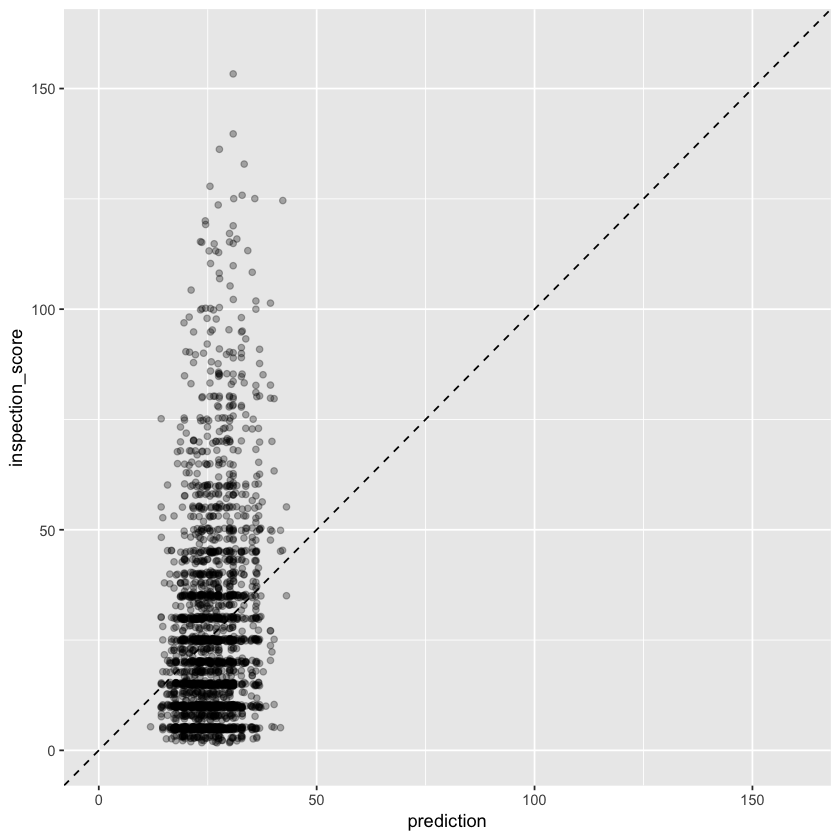

In [13]:
#run this cell to see the plot
ggplot(test_sub,aes(x=prediction,y=inspection_score)) + geom_jitter(alpha=.3) + geom_abline(linetype = "dashed") +
  scale_x_continuous(limits = c(0, 160)) +
  scale_y_continuous(limits = c(0, 160))

Variable importance measures can be used to see which variables are driving the predictive ability of the model. You can see the variable importance measures for our model by using `summary(model, plotit=FALSE)`. The importance measure (rel.inf) used here is based off the number of times a variable is used for splitting the trees in the model, weighted by the squared improvement to the model after each split, averaged over all the trees in the model. Do both variables in this model have a lot of influence, or is one dominating the other?

In [14]:
summary(gb_ziponly,plotit=FALSE)

,var,rel.inf
business_location_zip,business_location_zip,85.09134
year,year,14.90866


Consider the fact that inspectors are assigned by zip code, and some inspectors are more harsh than others when grading (see https://www.thestranger.com/seattle/mr-clean/Content?oid=568012). What will this mean if the allocation of resources for inspections is dictated by a model that takes zip code into account when predicting scores? Is this the best way of targeting health inspections? Is it fair?

## Using inspection level data

Since the RMSE for the model with zip code wasn't much smaller than our baseline, let's add previous inspection scores to see if there is any improvement.

In [15]:
#fit a gradient boosted tree model (using gbm()) with previous inspection scores added in
gb_inspect <- gbm(inspection_score~business_location_zip+prev_score_1 + prev_score_2 + prev_score_3 + prev_score_4 +
          year,data=train_sub,distribution = "gaussian",n.trees = 1000,shrinkage = 0.01)

In [16]:
#predict the inspection scores with the new model and calculate RMSE - name the value 'inspect_only'
score_pred_inspect <- predict(gb_inspect,newdata=test_sub,n.trees=1000)
inspect_only <- sqrt(mean((score_pred_inspect-test_sub$inspection_score)^2))


In [17]:
#run this cell to add new RMSE value to our table of results
results <- rbind(results,cbind(Model='Inspections GBM',RMSE=inspect_only))
results

Model,RMSE
Naive,22.8355359689342
Zip Code GBM,22.2351920154707
Inspections GBM,21.3046030630831


The RMSE for the model with the inspection data is lower the model using just zip code by about 1 point. Let's look at variable importance for this model.

In [18]:
summary(gb_inspect,plotit=FALSE)

,var,rel.inf
prev_score_1,prev_score_1,40.696369
business_location_zip,business_location_zip,32.679623
prev_score_2,prev_score_2,9.516190
year,year,7.438217
prev_score_3,prev_score_3,5.272536
prev_score_4,prev_score_4,4.397065


Since zip code was a very influential variable but the predictive ability of the model with just zip code wasn't much better than the baseline, what might this mean about the information the other variables in the model are representing?

## Including cuisine category

Let's try adding the Asian restaurant indicator to see if this extra variable will improve accuracy. Don't include zip code in this model.

In [20]:
#fit another gradient boosted tree model here
gb_asian <- gbm(inspection_score~prev_score_1 + prev_score_2 + prev_score_3 + prev_score_4 +
          year + weekday + asian,data=train_sub
          ,distribution = "gaussian",n.trees = 1000,shrinkage = 0.01)

In [21]:
#predict the inspection scores and calculate RMSE - name RMSE value 'rmse_asian'
score_pred_asian <- predict(gb_asian,newdata=test_sub,n.trees=1000)

rmse_asian <- sqrt(mean((score_pred_asian-test_sub$inspection_score)^2))


In [22]:
#run this column to see updated results
results <- rbind(results,cbind(Model="With Asian GBM",RMSE=rmse_asian))
results

Model,RMSE
Naive,22.8355359689342
Zip Code GBM,22.2351920154707
Inspections GBM,21.3046030630831
With Asian GBM,21.1549082908779


In [23]:
#look at variable importance
summary(gb_asian,plotit=FALSE)

,var,rel.inf
prev_score_1,prev_score_1,49.12569874
asian,asian,16.34795059
prev_score_2,prev_score_2,12.67099862
year,year,8.97169593
prev_score_3,prev_score_3,7.27169134
prev_score_4,prev_score_4,5.58567586
weekday,weekday,0.02628893


Looking at the RMSE, including the Asian food indicator doesn't seem to improve the model either. It is the second most influential variable, but the relative influence compared to the most recent inspection score is still low. We can look futher into how the Asian food indicator is affected the prediction by recreating the calibration plot and predicted vs actual plots from before. We'll breakdown the calibration plot by Asian vs non-Asian restaurants.

In [24]:
test_sub$prediction_w_asian <- score_pred_asian
test_sub$countCatAsian <- ntile(test_sub$prediction_w_asian,10) 

#you will need to split the test subset into two dataframes of Asian and non-Asian restaurants
justAsian <- test_sub[test_sub$asian==1,]
justNonAsian <- test_sub[test_sub$asian==0,]

#data for calibration plot for model with just Asian restaurants - name it 'calibration_data_asian'
#name the columns 'meanScore' for the mean of each bin, 'predMidpoint' for the midpoint of the bins and 
# 'n' for the count of points in each bin
calibration_data_asian <- justAsian %>% 
                    group_by(countCatAsian) %>%
                    summarize(meanScore = mean(inspection_score),
                              predMidpoint=midpoint(prediction),
                              n = n())

#data for calibration plot for model with just non-Asian restaurants - name it 'calibration_data_nonasian'
#name columns the same way as before
calibration_data_nonasian <- justNonAsian %>%
                                group_by(countCatAsian) %>%
                                summarize(meanScore=mean(inspection_score),
                                          predMidpoint=midpoint(prediction),
                                          n = n())

# adding column to differentiate groups
calibration_data_nonasian <- add_column(calibration_data_nonasian,type="NonAsian")
calibration_data_asian <- add_column(calibration_data_asian,type="Asian")
#bind your two data sets together and call it 'calibration_dat'
calibration_dat <- bind_rows(calibration_data_nonasian,calibration_data_asian)

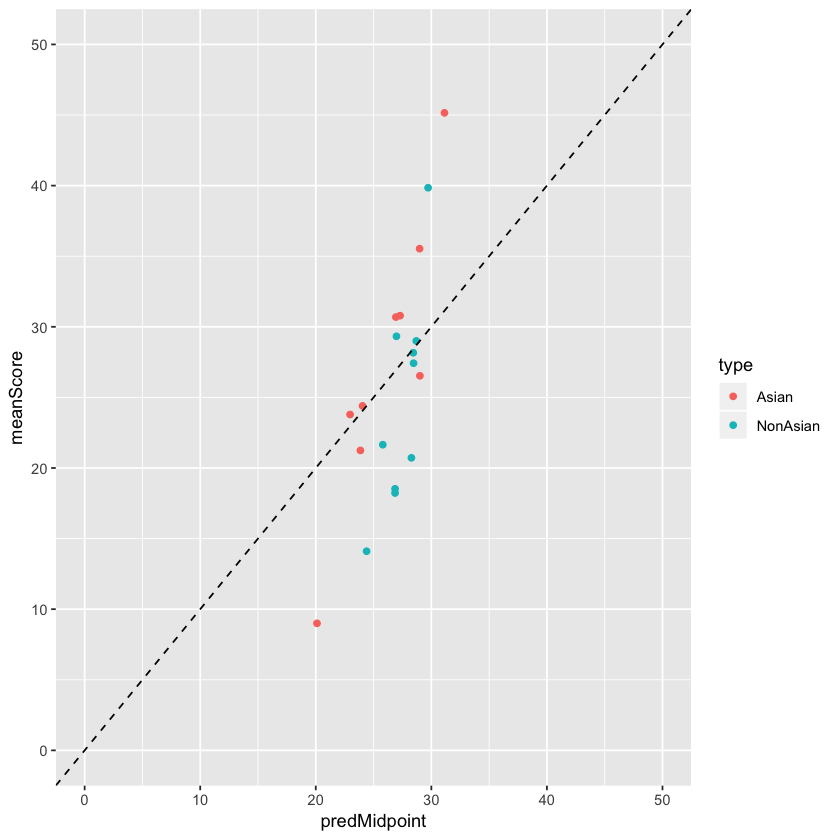

In [25]:
#run this cell to plot data
ggplot(calibration_dat,aes(x=predMidpoint,y=meanScore,group=type)) +  
    geom_point(aes(color=type)) + 
    geom_abline(linetype = "dashed") +
    scale_x_continuous(limits = c(0, 50)) +
    scale_y_continuous(limits = c(0, 50))

Say we want a to set a cutoff of 35 points for an inspection score to indicate a high risk restaurant. Let's look at the false positive rates for the Asian vs non-Asian restaurants for this model including the Asian indicator.

In [26]:
#Add two boolean columns to test_sub to indicate if the predicted score was equal to or above 35 named 'pred_above_cut' 
#and the observed score was equal to orabove 35 named 'above_cut'
test_sub <- test_sub %>% 
    mutate(pred_above_cut = prediction_w_asian >= 35, above_cut = inspection_score >= 35)


We can use the `table()` function to create confusion matrices for the Asian and non-Asian subgroups, and then calculate the false positive rate. The false positive rate is the count of false positives (scores predicted above 35 that were not observed to be above 35) divided by the sum of false positives and true negatives (scores predicted to be below 35 and observed below 35).

In [27]:
#run this cell to see the the confusion matrices
table(pred=test_sub$pred_above_cut,actual=test_sub$above_cut,asian=test_sub$asian)

, , asian = 0

       actual
pred    FALSE TRUE
  FALSE  1305  325
  TRUE     36   27

, , asian = 1

       actual
pred    FALSE TRUE
  FALSE   458  226
  TRUE    101  130


In [28]:
#calculate false positive rates
#for non asian restaurants
45/(45+1296)
#for asian restaurants
113/(113+446)

[1] 0.03355705

[1] 0.2021467

The false positive (FP) rate is about 3% for non-Asian restaurants but about 20% for Asian restaurants! Let's look at the distributions of the scores for Asian vs non-Asian restaurants, including a line to indicate where we set our cutoff.

Plot the density distribution of the inspection scores grouped by the Asian restaurant indicator.

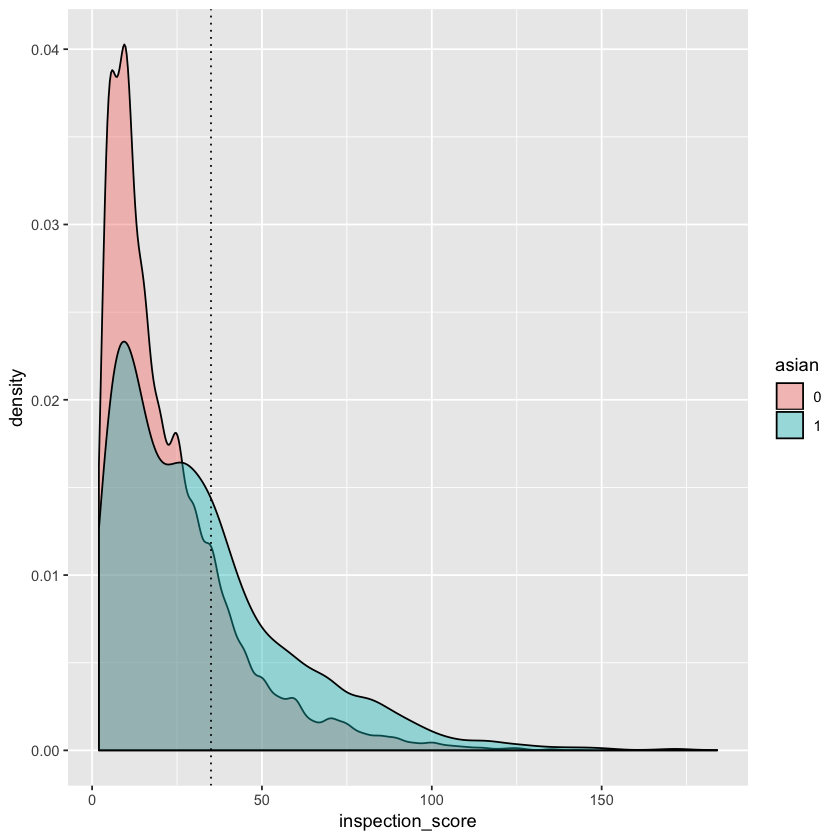

In [29]:
#run this cell to plot the densities
ggplot(kcDat, aes(x=inspection_score, fill=asian)) +
  geom_density(alpha=0.4) + geom_vline(xintercept = 35, linetype="dotted")

We can see from the distributions that no matter where the cutoff is set, more Asian restaurants will be marked as high risk than non Asian restaurants. Is this fair? Would it be more fair to set a cutoff for non Asian restaurants and a different cutoff for Asian restaurants so that false postive rates are equal?

Questions to consider:

   - Which model would you pick? Why?
   - Is the model you would pick fair? What does fair mean in this context?
   - Consider this paper by Kang et al.: https://www.aclweb.org/anthology/D13-1150. Do you agree with the choice to use Yelp data to predict inspection results? What problems might there be with this approach?
   - What other data might you be interested in adding to your model? Are there any potential biases or drawbacks to adding the data?
   


References

   - [Is Yelp Actually Cleaning Up the Restaurant Industry? A Re-Analysis on the Relative Usefulness of Consumer Reviews](https://dho.stanford.edu/wp-content/uploads/YelpReplicate_FinalWWW2019_neutral.pdf) WWWW Proceedings (2019) (with Kristen M. Altenburger)
   - [When Algorithms Import Private bias into Public Enforcement: The Promise and Limitations of Statistical Debiasing Solutions](https://dho.stanford.edu/wp-content/uploads/JITE-FinalVersion.pdf) 175 Journal of Institutional and Theoretical Economics 98-122 (with Kristen M. Altenburger)